In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

##  Flowers Data

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

In [3]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../input'      # location where input data is stored
outDir = '../output'     # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 50      # number of cycles to run
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1
BATCH_SIZE = 32    # inline of Training Rows being 60000
IMG_HEIGHT = 190   # ???
IMG_WIDTH = 190   # ???


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
print (physical_devices)

[]


In [6]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [7]:
'''import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''


data_dir = os.path.join(inpDir, subDir)
data_dir

'../input\\flower_photos'

In [8]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3279 files belonging to 5 classes.
Using 2624 files for training.
Found 3279 files belonging to 5 classes.
Using 655 files for validation.


In [9]:
#delete these lines -- if necessary

labels = []
for count, data in enumerate(train_ds) :
    imgs, lbls = data
    #print(count, ' : ', imgs.shape, lbls.shape)
    labels.append(lbls)

#len(labels)

unique, A, counts = tf.unique_with_counts(tf.concat(labels, axis = 0).numpy())

unique, A, counts

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([4, 1, 3, 0, 2])>,
 <tf.Tensor: shape=(2624,), dtype=int32, numpy=array([0, 1, 0, ..., 0, 2, 0])>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([653, 722, 553, 491, 205])>)

In [10]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [11]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
class_dict = {k: v for k, v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [13]:
num_classes = len(class_names)
num_classes

5

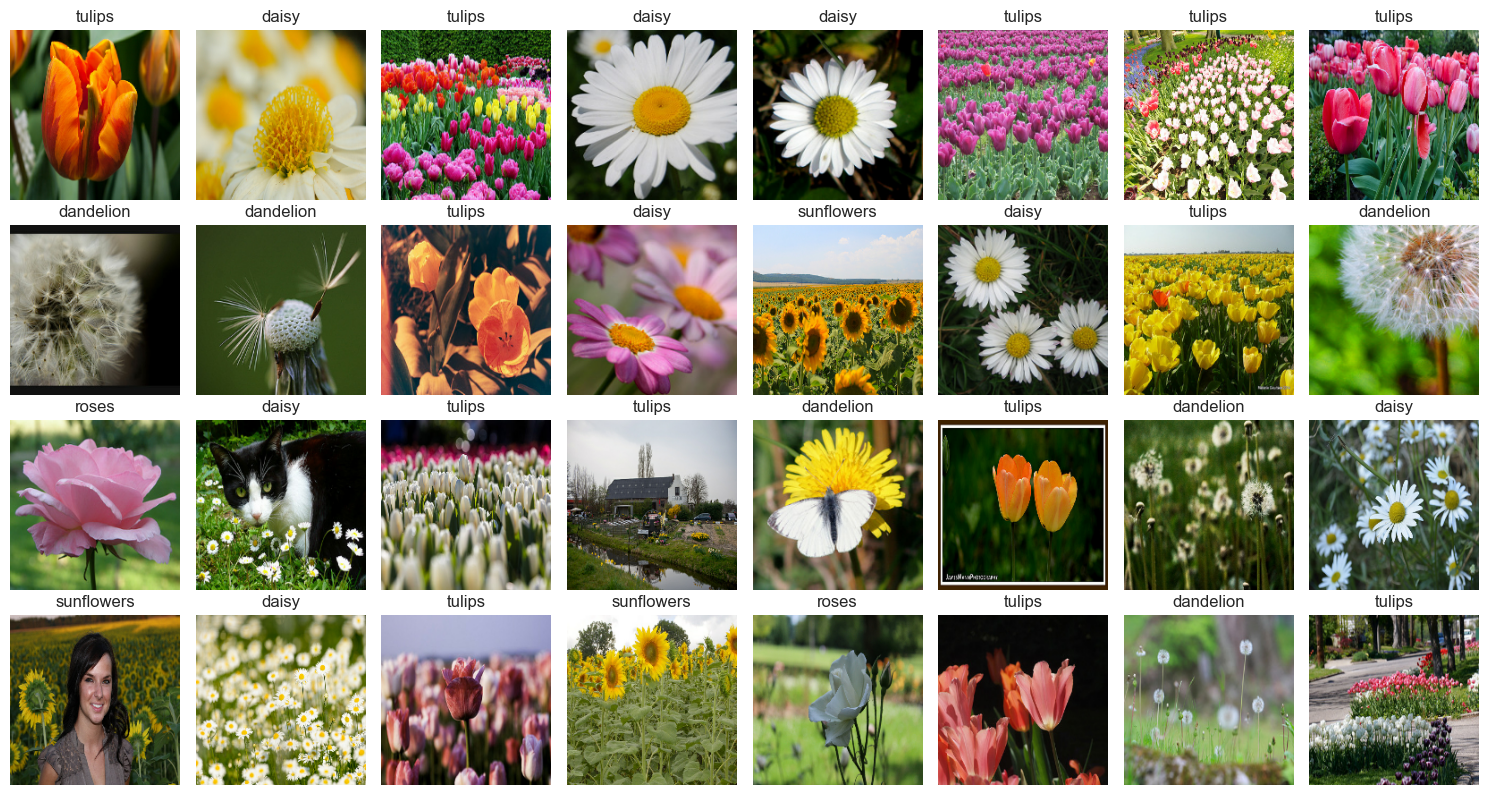

In [14]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

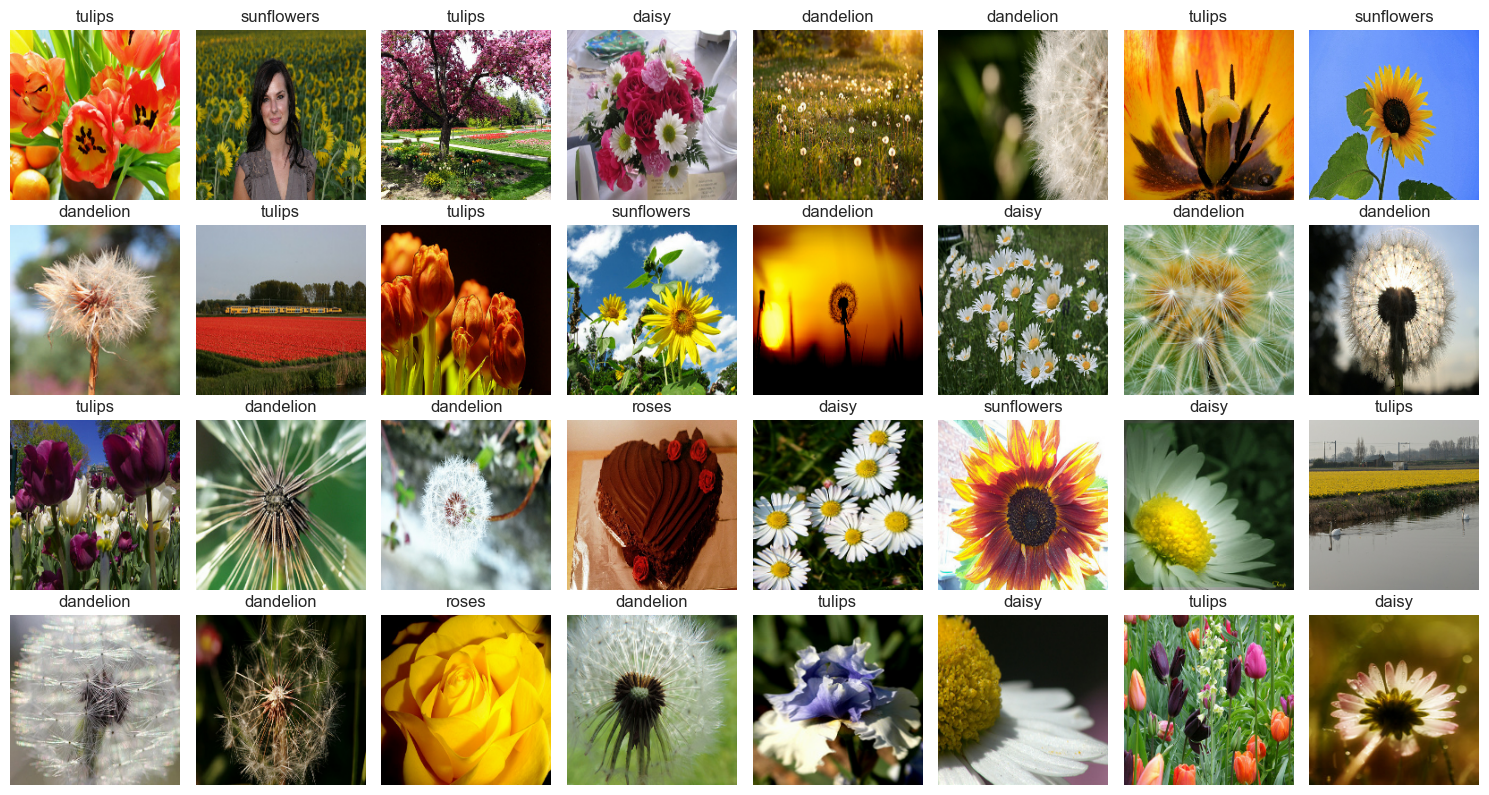

In [15]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch
    
    for i in range (BATCH_SIZE): # loop over batch
        
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        
        plt.grid(False) # no to grid
        
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
    
    plt.tight_layout()

plt.show()

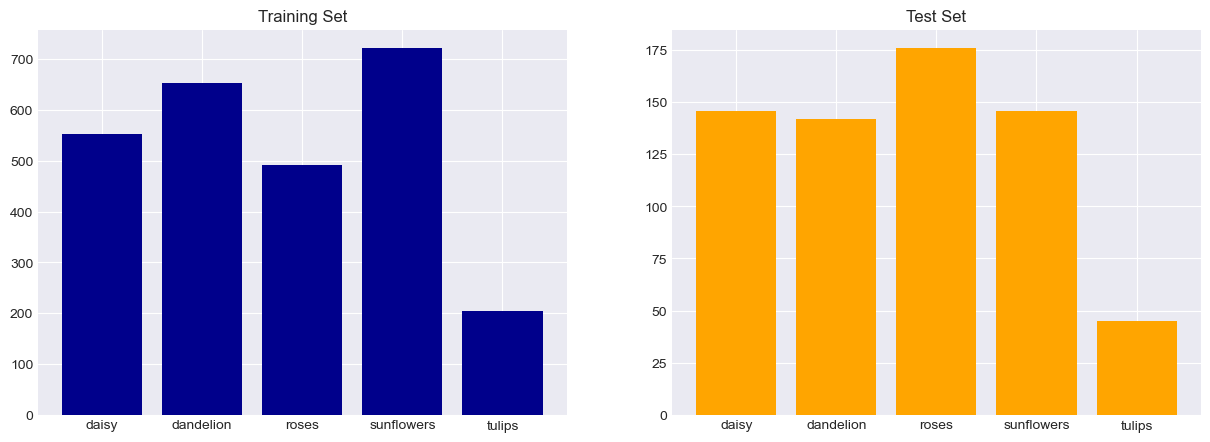

In [16]:
fn_plot_label(train_ds, test_ds)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(190, 190, 3)

In [18]:
def build_model(input_shape, num_classes):

  krnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

  model = tf.keras.Sequential()

  tf.keras.layers.Rescaling(1./255)

#---------------------------------------------------------------------------
#Augmentation Layers here

#------------------------------------------------------------------------------

 #Set 1
 #conv 1
  model.add(tf.keras.layers.Conv2D(32, (3, 3),
    kernel_initializer = krnl_init, 
    activation ='relu',                           
    input_shape = input_shape))         #188 x 188 x 32
  #Max pool layer
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 94 X 94 X 32


  #Set 2 
  #conv 2
  model.add(tf.keras.layers.Conv2D(64, (3, 3),
    kernel_initializer = krnl_init, 
    activation ='relu'))         #92 x 92 x 64
  #Max pool layer
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 46 X 46 X 64


  #Set 3 
  #conv 3
  model.add(tf.keras.layers.Conv2D(128, (3, 3),
    kernel_initializer = krnl_init, 
    activation ='relu'))         #44 x 44 x 128
  #Max pool layer
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 22 X 22 X 128


  #Set 4
  #conv 4
  model.add(tf.keras.layers.Conv2D(256, (3, 3),
    kernel_initializer = krnl_init, 
    activation ='relu'))         #20 x 20 x 256
  #Max pool layer
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 10 X 10 X 256


  #Set 5
  #conv 5
  model.add(tf.keras.layers.Conv2D(512, (3, 3),
    kernel_initializer = krnl_init, 
    activation ='relu'))         #8 x 8 x 512
  #Max pool layer
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 4 X 4 X 512


  #Set 6
  #conv 6
  model.add(tf.keras.layers.Conv2D(1024, (3, 3),
    kernel_initializer = krnl_init, 
    activation ='relu'))         #2 x 2 x 1024


#-------------------------------------------------------------------------

  # Head

  model.add(tf.keras.layers.Flatten())

  #Dense 1
  model.add(tf.keras.layers.Dense(512, 
                                activation = 'relu', 
                                kernel_initializer = krnl_init))
  #Dense 2
  model.add(tf.keras.layers.Dense(64, 
                                activation = 'relu', 
                                kernel_initializer = krnl_init))

  #Dense 3
  model.add(tf.keras.layers.Dense(num_classes))

  return model 

In [19]:
model = build_model(input_shape, num_classes)
model

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(
              learning_rate=ALPHA),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
checkpoint_path = os.path.join(modelDir, subDir, 'flowers')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True)

es_checkpoint = tf.keras.callbacks.EarlyStopping( #early stopping call back, after some time 
    monitor='val_loss',                           #if there is no change in loss then assume it is only your good weights
    patience=PATIENCE,
    mode='auto',
    restore_best_weights=True
)

lr_checkpoint = tf.keras.callbacks.ReduceLROnPlateau(   #learning rate call back used for decreasing learning rate, when loss is not improving
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1

)

In [22]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks = [model_checkpoint, es_checkpoint, lr_checkpoint],
                    verbose=2)

Epoch 1/50



Epoch 1: val_loss improved from inf to 1.43910, saving model to ../models\flower_photos\flowers
82/82 - 51s - loss: 3.7586 - accuracy: 0.2755 - val_loss: 1.4391 - val_accuracy: 0.3481 - lr: 0.0010 - 51s/epoch - 625ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.43910 to 1.38253, saving model to ../models\flower_photos\flowers
82/82 - 46s - loss: 1.3795 - accuracy: 0.3921 - val_loss: 1.3825 - val_accuracy: 0.4000 - lr: 0.0010 - 46s/epoch - 566ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.38253 to 0.99544, saving model to ../models\flower_photos\flowers
82/82 - 46s - loss: 1.1311 - accuracy: 0.5625 - val_loss: 0.9954 - val_accuracy: 0.6229 - lr: 0.0010 - 46s/epoch - 564ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.99544
82/82 - 45s - loss: 0.9964 - accuracy: 0.6246 - val_loss: 1.0148 - val_accuracy: 0.6183 - lr: 0.0010 - 45s/epoch - 553ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.99544 to 0.90018, saving model to ../models\flower_photos

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 188, 188, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 94, 94, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 128)       0

In [24]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy     lr
0  3.758644  0.275534  1.439097      0.348092  0.001
1  1.379482  0.392149  1.382529      0.400000  0.001
2  1.131081  0.562500  0.995437      0.622901  0.001
3  0.996445  0.624619  1.014789      0.618321  0.001
4  0.931716  0.647485  0.900181      0.650382  0.001

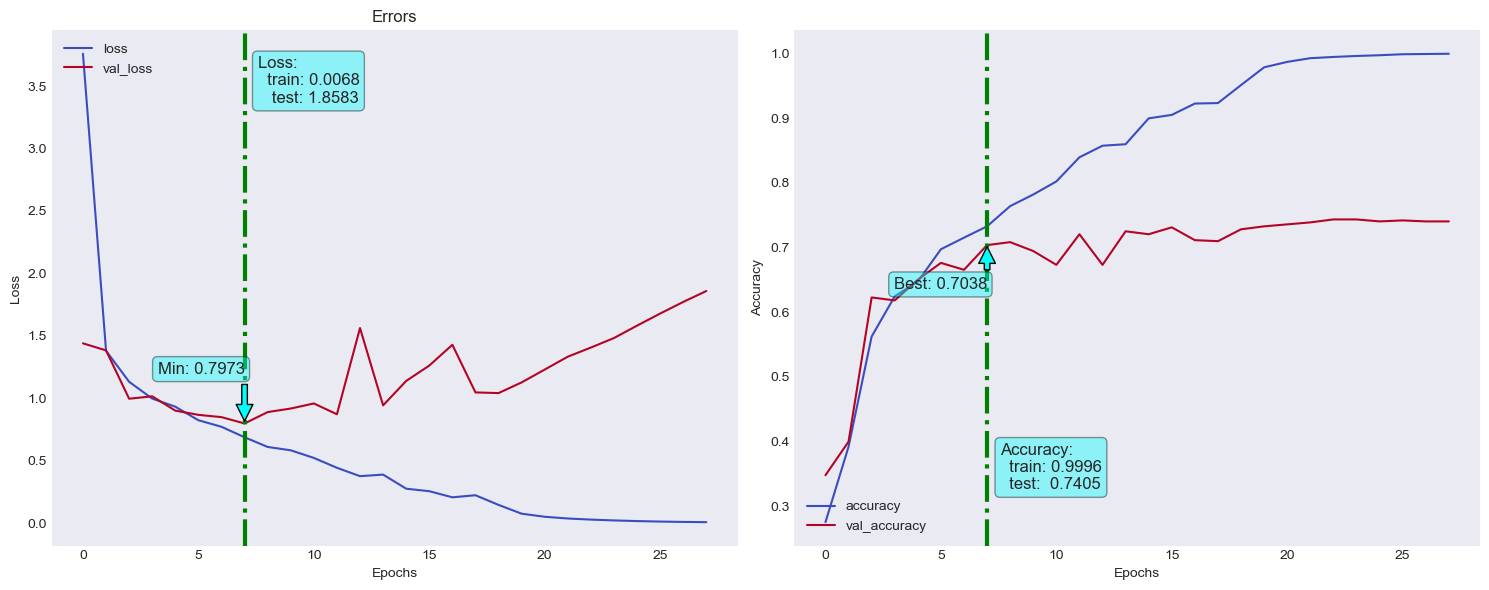

In [25]:
fn_plot_tf_hist(loss_df)

In [27]:
'''
tf.keras.utils.plot_model(model, 'model.png',
                          show_shapes=True,
                          show_dtype=True,
                          dpi=96,
                          show_layer_activations=True)
'''

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


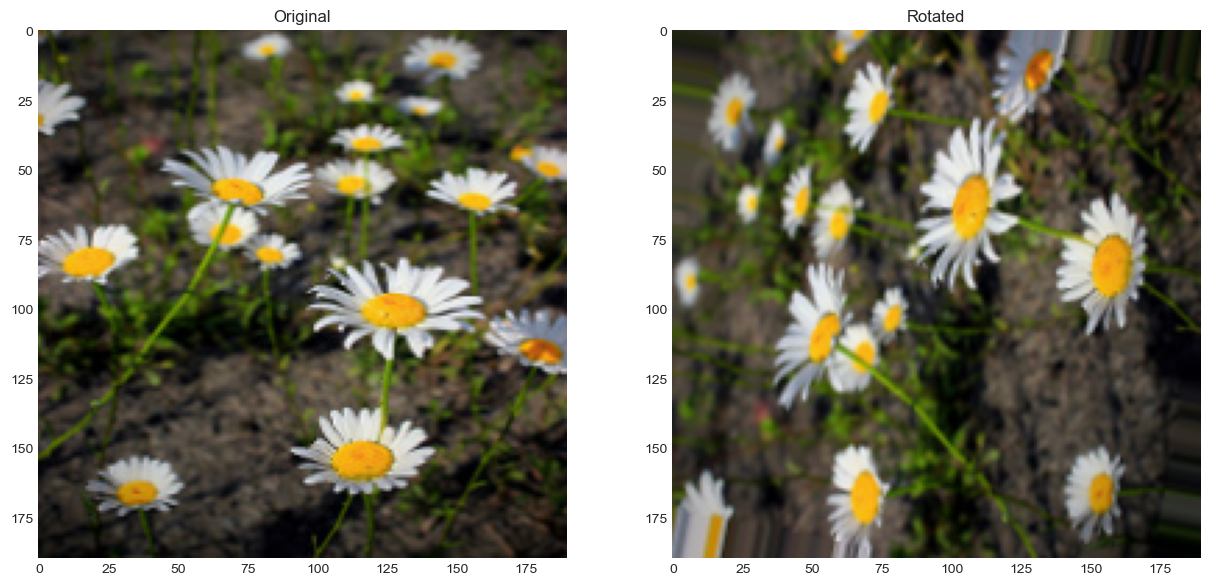

In [32]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
    fill_mode='nearest',
    seed = RANDOM_STATE
)
plt.figure()

img_num = 0
for images, labels in train_ds.take(1) :
    out_images = layer(images)
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.title("Rotated")
    plt.imshow(out_images[img_num].numpy().astype('uint16'))
    plt.grid(False)
    